<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Motion Activity Classification Using Recurrent Neural Networks </centre></strong></h1>

<h2 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Methodology: Model Architecture </centre></strong></h2>

#### 03.Model Development
**Objective:** Train a Tradicional RNN model on the preprocessed dataset.

**Model Training:** <br>
<br>
 - **Base Model:**
    + Defines the CNN architecture using Keras layers such as Conv2D, MaxPooling2D, Flatten, Dense, and Dropout.
    + Compiles the model with the Adam optimizer and categorical cross-entropy loss.
 
 - **Training and Evaluation:**
    + Utilizes EarlyStopping and ModelCheckpoint callbacks for efficient training.
    + Trains the model and evaluates its performance on the validation set.
    + Includes code to visualize training and validation accuracy over epochs.

---

## **Carregamento das Bibliotecas Base**

In [4]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import time
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization


import warnings
warnings.filterwarnings('ignore')

## **Carregamento e Leitura do *Dataset* Pré-processado**

In [8]:
# Definir o caminho do ficheiro relativo ao dataset
file_path = os.path.join(os.getcwd(), 'RNN_dataset', 'concatDataset.csv')

#print(file_path)

+ Utilização do método `read_csv()` para leitura do arquivo CSV com os dados pré-processados

In [14]:
df_motionSense = pd.read_csv(file_path)

+ Visualização das 5 primeiras linhas do *dataset* utilizando o método `head()`

In [15]:
df_motionSense.head(5)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,category_encoded
0,0.972412,1.112051,0.372160,2.329043,-0.814143,0.190001,0.163109,0.417746,0.891213,0.591696,-0.307112,0.677785,0
1,0.972325,1.157371,0.361670,2.365755,-0.865384,0.187932,0.443882,0.221714,0.524710,0.436217,-0.038492,0.186239,0
2,0.972184,1.184141,0.357830,2.387092,-0.896006,0.186328,-0.080028,-0.036082,0.274351,0.006391,0.082024,-0.342729,0
3,0.965350,1.190361,0.360527,2.390690,-0.903162,0.156397,-0.019555,-0.594680,0.017573,-0.032954,0.084569,0.148985,0
4,0.951164,1.192398,0.358982,2.388570,-0.905503,0.094676,0.054879,-0.519408,0.027154,0.395098,0.349372,-0.111607,0


## **Definição de Variáveis Fixas**

In [ ]:
NUM_FEATURES = df_motionSense.shape[1] - 1
NUM_CLASSES = df_motionSense['category_encoded'].nunique()
EPOCHS = 50

## **Preparação do *Dataset***

+ A função `prepare_data()` realiza o pré-processamento necessário para treinar um modelo de classificação de atividades baseado em RNNs. Este cria sequências de dados a partir da função `create_sequence()` e divide o conjunto de dados em treino e teste.

Esta divisão foi feita com base na função `train_test_split()` do scikit-learn que permite dividir o conjunto de dados em conjuntos de treino e teste. Este separa as *features* ('x_columns') e a *target* ('y_columns') com um tamanho de conjunto de teste de, neste caso, 20% (`test_size=0.2`), garantindo que os comprimentos dos conjuntos de treino para *features* e *targets* sejam os mesmos.

In [16]:
def prepare_data(df, window_length):
    """
    Preprocesses the dataset for training an RNN-based activity classification model.

    Args:
        df (pandas.DataFrame): The input dataset containing features and labels.
        window_length (int): The desired length of the time window for creating sequences.

    Returns:
        X_train, X_test, y_train, y_test: Processed training and testing data.
    """
    def create_sequences(data, target, window_size):
        sequences = []
        targets = []
        for i in range(len(data) - window_size):
            seq = data[i:i+window_size]
            label = target[i+window_size]
            sequences.append(seq)
            targets.append(label)
        return np.array(sequences), np.array(targets)
    
    y = df['category_encoded']
    X = df.drop(columns=['category_encoded'])
    
    X_seq, y_seq = create_sequences(X, y, window_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    
    y_train = to_categorical(y_train, num_classes=y.nunique())
    y_test = to_categorical(y_test, num_classes=y.nunique())
    
    return X_train, X_test, y_train, y_test

## **Definição de métodos de Regularização**

Os callbacks `EarlyStopping` e `ReduceLROnPlateau` são ferramentas essenciais para otimizar o treino de modelos de Deep Learning no TensorFlow Keras.

+ O `EarlyStopping` interrompe o treino quando uma métrica específica, como a perda de validação (`val_loss`), não mostra melhorias por um número definido de épocas (`patience=10`);    , prevenindo o sobreajuste.

+ O `ReduceLROnPlateau` ajusta dinamicamente a taxa de aprendizagem (`factor=0.2`) do otimizador se a métrica monitorizada (`val_loss`) não apresentar melhorias após um número específico de épocas (`patience=5`), permitindo uma convergência mais suave do modelo.

Usados em conjunto, estes callbacks melhoram a eficiência e a qualidade do treino, bem como ajudam a alcançar um equilíbrio entre o desempenho do modelo e a eficiência computacional.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## **Definição da Função de Visualização da Avaliação**

In [19]:
def plot_training_results(history):
    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Loss")

    plt.tight_layout()
    plt.show()

## **Definição das Arquiteturas com camadas LSTM - Single Layer**

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 7 </centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,303 (59.78 KB)

 Trainable params: 15,303 (59.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9152 - loss: 0.2344 - val_accuracy: 0.9696 - val_loss: 0.0903 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.9713 - loss: 0.0839 - val_accuracy: 0.9768 - val_loss: 0.0672 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - accuracy: 0.9796 - loss: 0.0586 - val_accuracy: 0.9806 - val_loss: 0.0537 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - accuracy: 0.9841 - loss: 0.0446 - val_accuracy: 0.9860 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9880 - loss: 0.0337 - val_accuracy: 0.9871 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 75s 7ms/step - accuracy: 0.9902 - loss: 0.0276 - val_accuracy: 0.9894 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step -

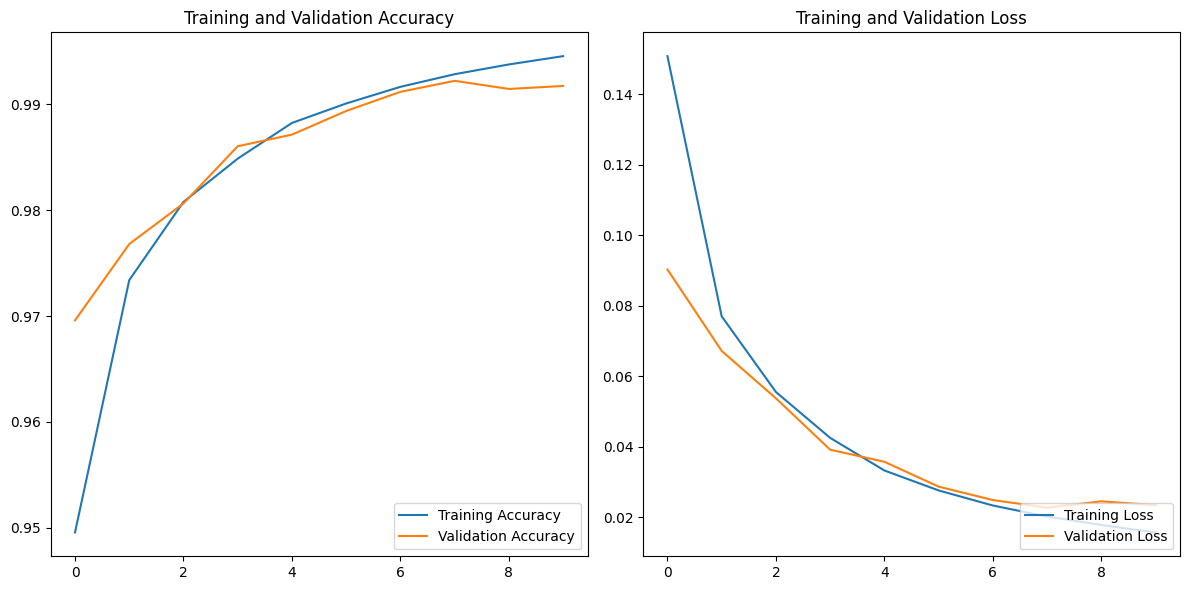

In [ ]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_7 = Sequential([
    Input((WINDOW_LENGTH, NUM_FEATURES)),
    LSTM(50, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_7.summary()

model_7.save('../models/model_7/model_7_h19.keras')

start_time = time.time()

history_19 = model_7.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_7/history_19.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_19.history, file)


loss, accuracy = model_7.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_19)

---

### **Janela Temporal = 30**

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,303 (59.78 KB)

 Trainable params: 15,303 (59.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - accuracy: 0.9256 - loss: 0.2038 - val_accuracy: 0.9769 - val_loss: 0.0678 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 75s 7ms/step - accuracy: 0.9804 - loss: 0.0580 - val_accuracy: 0.9889 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9882 - loss: 0.0343 - val_accuracy: 0.9895 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.9922 - loss: 0.0226 - val_accuracy: 0.9922 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9944 - loss: 0.0162 - val_accuracy: 0.9947 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9961 - loss: 0.0123 - val_accuracy: 0.9970 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 75s 7ms/step -

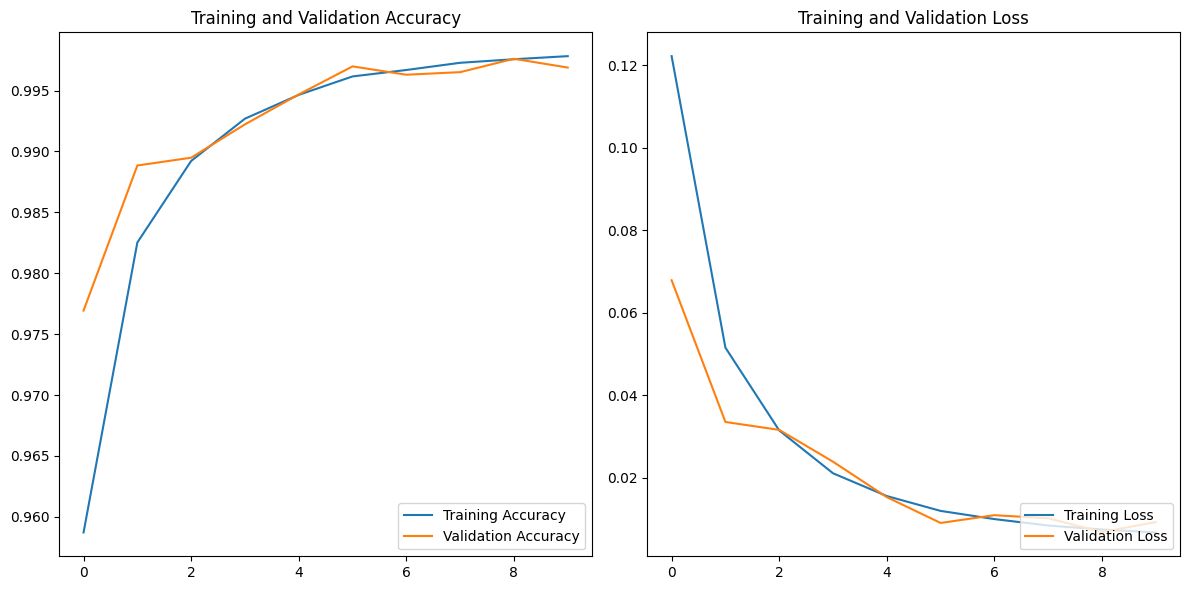

In [22]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_7 = Sequential([
    Input((WINDOW_LENGTH, NUM_FEATURES)),
    LSTM(50, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_7.summary()

model_7.save('../models/model_7/model_7_h20.keras')

start_time = time.time()

history_20 = model_7.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_7/history_20.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_20.history, file)


loss, accuracy = model_7.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_20)

---

### **Janela Temporal = 50**

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,303 (59.78 KB)

 Trainable params: 15,303 (59.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 123s 11ms/step - accuracy: 0.9348 - loss: 0.1823 - val_accuracy: 0.9843 - val_loss: 0.0490 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 116s 11ms/step - accuracy: 0.9866 - loss: 0.0401 - val_accuracy: 0.9918 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 141s 13ms/step - accuracy: 0.9933 - loss: 0.0201 - val_accuracy: 0.9947 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - accuracy: 0.9962 - loss: 0.0123 - val_accuracy: 0.9966 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 131s 12ms/step - accuracy: 0.9975 - loss: 0.0079 - val_accuracy: 0.9982 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 123s 12ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9987 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 12

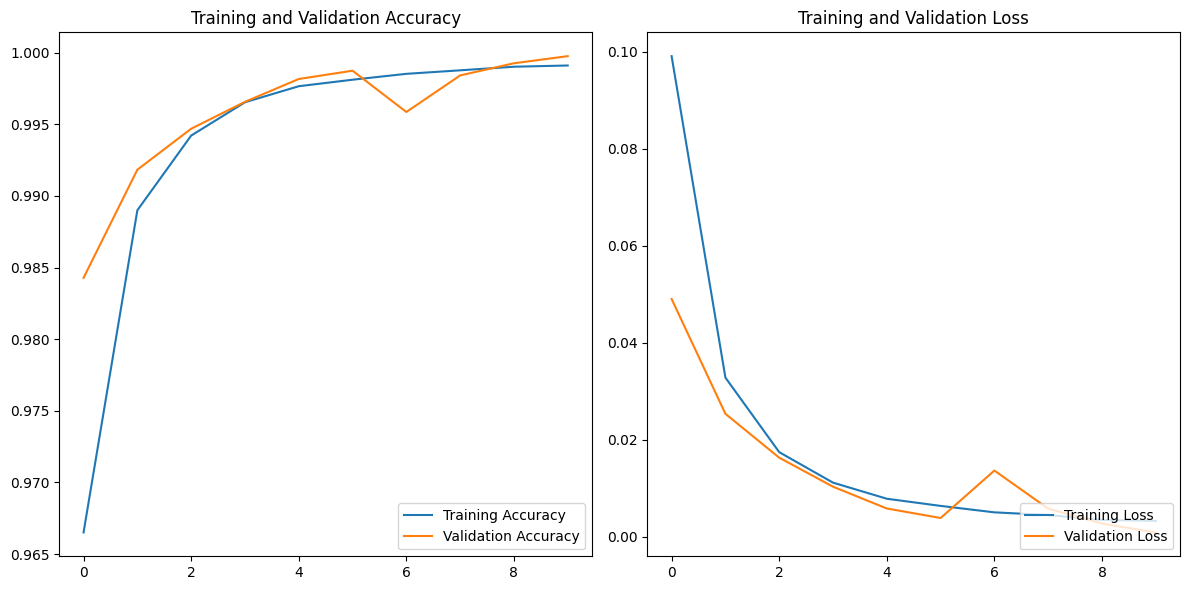

In [23]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_7 = Sequential([
    Input((WINDOW_LENGTH, NUM_FEATURES)),
    LSTM(50, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_7.summary()

model_7.save('../models/model_7/model_7_h21.keras')

start_time = time.time()

history_21 = model_7.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_7/history_21.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_21.history, file)


loss, accuracy = model_7.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_21)

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 8</centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,603 (217.20 KB)

 Trainable params: 55,603 (217.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - accuracy: 0.9133 - loss: 0.2409 - val_accuracy: 0.9703 - val_loss: 0.0883 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.9716 - loss: 0.0858 - val_accuracy: 0.9802 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - accuracy: 0.9806 - loss: 0.0577 - val_accuracy: 0.9882 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 89s 8ms/step - accuracy: 0.9857 - loss: 0.0416 - val_accuracy: 0.9904 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - accuracy: 0.9897 - loss: 0.0300 - val_accuracy: 0.9915 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.9917 - loss: 0.0255 - val_accuracy: 0.9934 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step

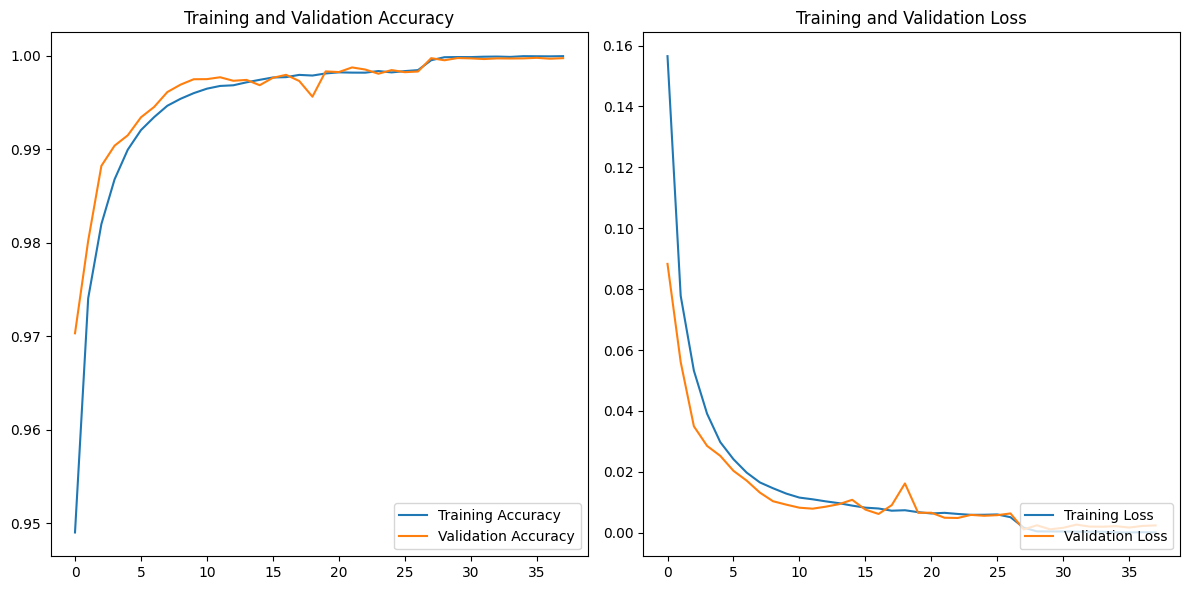

In [10]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_8 = Sequential([
    LSTM(100, input_shape=(WINDOW_LENGTH,NUM_FEATURES)),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_8.summary()

model_8.save('../models/model_8/model_8_h22.keras')

start_time = time.time()

history_22 = model_8.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_8/history_22.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_22.history, file)


loss, accuracy = model_8.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_22)

---

### **Janela Temporal = 30**

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,603 (217.20 KB)

 Trainable params: 55,603 (217.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 155s 14ms/step - accuracy: 0.9275 - loss: 0.2036 - val_accuracy: 0.9792 - val_loss: 0.0626 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 151s 14ms/step - accuracy: 0.9807 - loss: 0.0601 - val_accuracy: 0.9893 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 148s 14ms/step - accuracy: 0.9888 - loss: 0.0334 - val_accuracy: 0.9931 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.9930 - loss: 0.0222 - val_accuracy: 0.9945 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.9947 - loss: 0.0168 - val_accuracy: 0.9974 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.9961 - loss: 0.0129 - val_accuracy: 0.9974 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 15

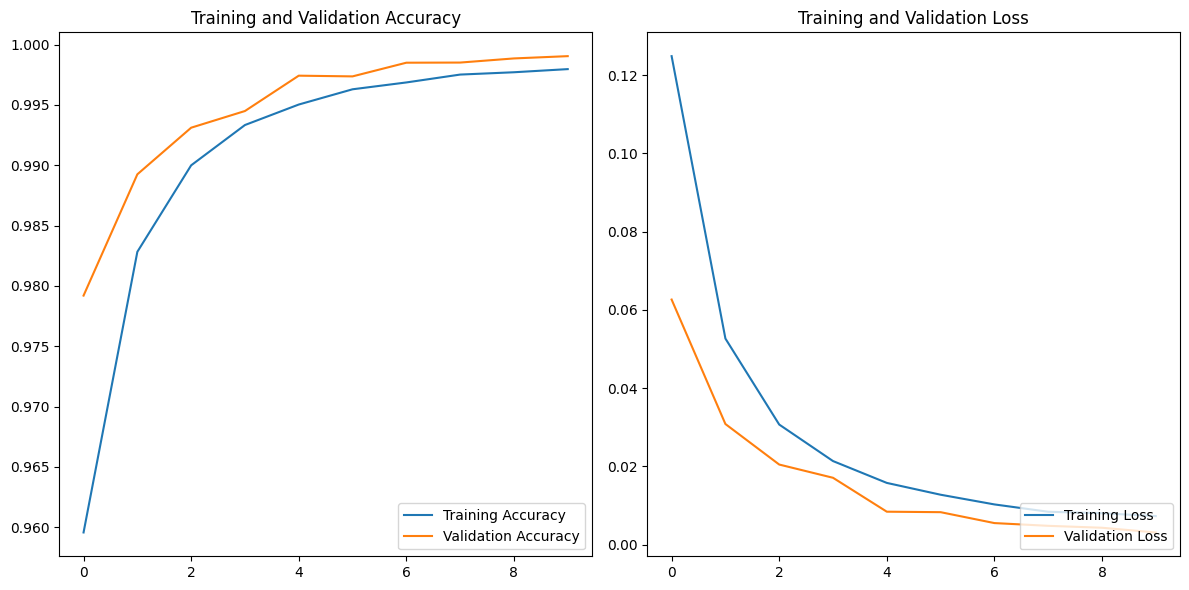

In [11]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_8 = Sequential([
    LSTM(100, input_shape=(WINDOW_LENGTH,NUM_FEATURES)),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_8.summary()

model_8.save('../models/model_8/model_8_h23.keras')

start_time = time.time()

history_23 = model_8.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_8/history_23.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_20.history, file)


loss, accuracy = model_8.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_23)

---

### **Janela Temporal = 50**

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,603 (217.20 KB)

 Trainable params: 55,603 (217.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 241s 22ms/step - accuracy: 0.9384 - loss: 0.1758 - val_accuracy: 0.9841 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 242s 23ms/step - accuracy: 0.9875 - loss: 0.0388 - val_accuracy: 0.9941 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 240s 23ms/step - accuracy: 0.9933 - loss: 0.0214 - val_accuracy: 0.9966 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 241s 23ms/step - accuracy: 0.9963 - loss: 0.0128 - val_accuracy: 0.9977 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 253s 24ms/step - accuracy: 0.9971 - loss: 0.0107 - val_accuracy: 0.9985 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 249s 24ms/step - accuracy: 0.9980 - loss: 0.0076 - val_accuracy: 0.9993 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 24

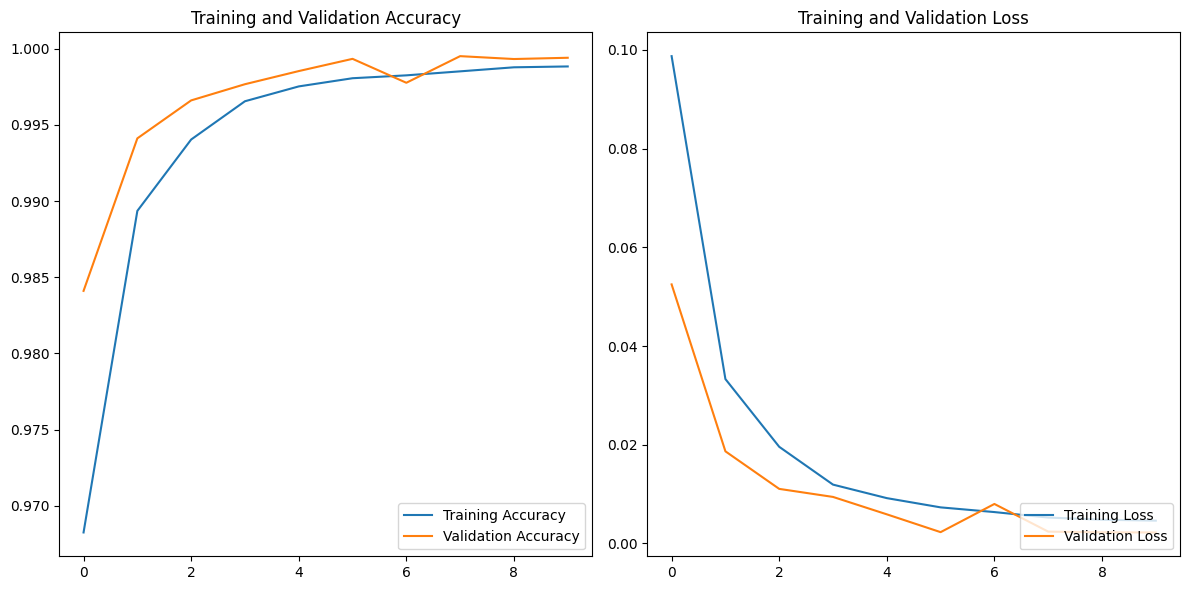

In [12]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_8 = Sequential([
    LSTM(100, input_shape=(WINDOW_LENGTH,NUM_FEATURES)),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_8.summary()

model_8.save('../models/model_8/model_8_h24.keras')

start_time = time.time()

history_24 = model_8.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_8/history_24.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_24.history, file)


loss, accuracy = model_8.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_24)

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 9</centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,303 (59.78 KB)

 Trainable params: 15,303 (59.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/step - accuracy: 0.8939 - loss: 0.2900 - val_accuracy: 0.9647 - val_loss: 0.1149 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 67s 6ms/step - accuracy: 0.9632 - loss: 0.1227 - val_accuracy: 0.9723 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 67s 6ms/step - accuracy: 0.9700 - loss: 0.0949 - val_accuracy: 0.9763 - val_loss: 0.0734 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.9757 - loss: 0.0779 - val_accuracy: 0.9800 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - accuracy: 0.9782 - loss: 0.0674 - val_accuracy: 0.9823 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9809 - loss: 0.0587 - val_accuracy: 0.9845 - val_loss: 0.0474 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 67s 6ms/step -

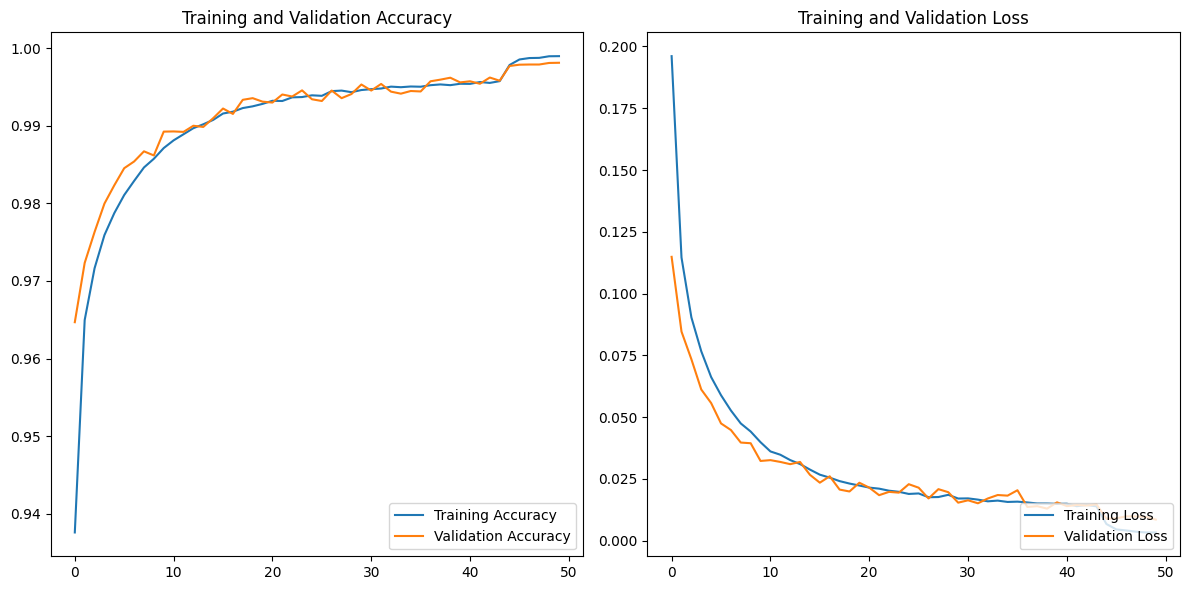

In [10]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_9 = Sequential([
    Input((WINDOW_LENGTH, NUM_FEATURES)),
    LSTM(100, return_sequences=False),
    Dropout(0.5),
    BatchNormalization(),
    Dense(50, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_9.summary()

model_9.save('../models/model_9/model_9_h25.keras')

start_time = time.time()

history_25 = model_9.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_9/history_25.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_25.history, file)


loss, accuracy = model_9.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_25)

---

### **Janela Temporal = 30**

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,803 (198.45 KB)

 Trainable params: 50,603 (197.67 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 140s 13ms/step - accuracy: 0.9163 - loss: 0.2335 - val_accuracy: 0.9773 - val_loss: 0.0645 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.9768 - loss: 0.0723 - val_accuracy: 0.9873 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.9853 - loss: 0.0447 - val_accuracy: 0.9913 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.9903 - loss: 0.0324 - val_accuracy: 0.9926 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 264s 25ms/step - accuracy: 0.9925 - loss: 0.0248 - val_accuracy: 0.9935 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 136s 13ms/step - accuracy: 0.9944 - loss: 0.0187 - val_accuracy: 0.9967 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 12

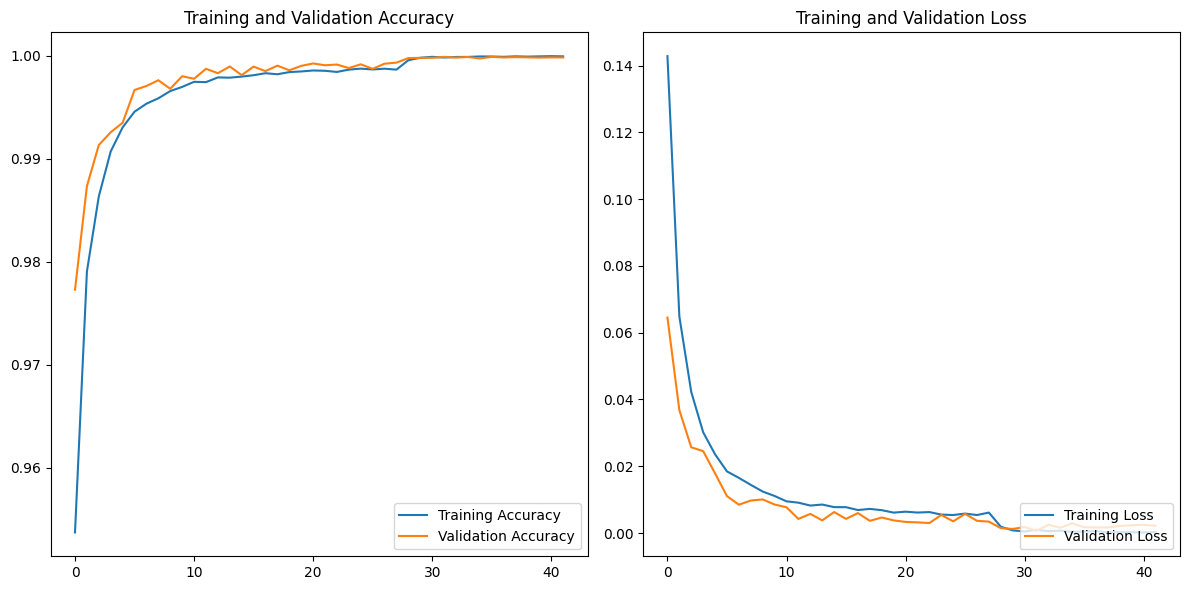

In [20]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_9 = Sequential([
    Input((WINDOW_LENGTH, NUM_FEATURES)),
    LSTM(100, return_sequences=False),
    Dropout(0.5),
    BatchNormalization(),
    Dense(50, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_9.summary()

model_9.save('../models/model_9/model_9_h26.keras')

start_time = time.time()

history_26 = model_9.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_9/history_26.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_26.history, file)


loss, accuracy = model_9.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_26)

---

### **Janela Temporal = 50**

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100)            │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,803 (198.45 KB)

 Trainable params: 50,603 (197.67 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 204s 18ms/step - accuracy: 0.9290 - loss: 0.2056 - val_accuracy: 0.9845 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 270s 25ms/step - accuracy: 0.9839 - loss: 0.0530 - val_accuracy: 0.9925 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 179s 17ms/step - accuracy: 0.9912 - loss: 0.0295 - val_accuracy: 0.9942 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 177s 17ms/step - accuracy: 0.9937 - loss: 0.0217 - val_accuracy: 0.9968 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 177s 17ms/step - accuracy: 0.9958 - loss: 0.0149 - val_accuracy: 0.9982 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 234s 22ms/step - accuracy: 0.9971 - loss: 0.0110 - val_accuracy: 0.9982 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 18

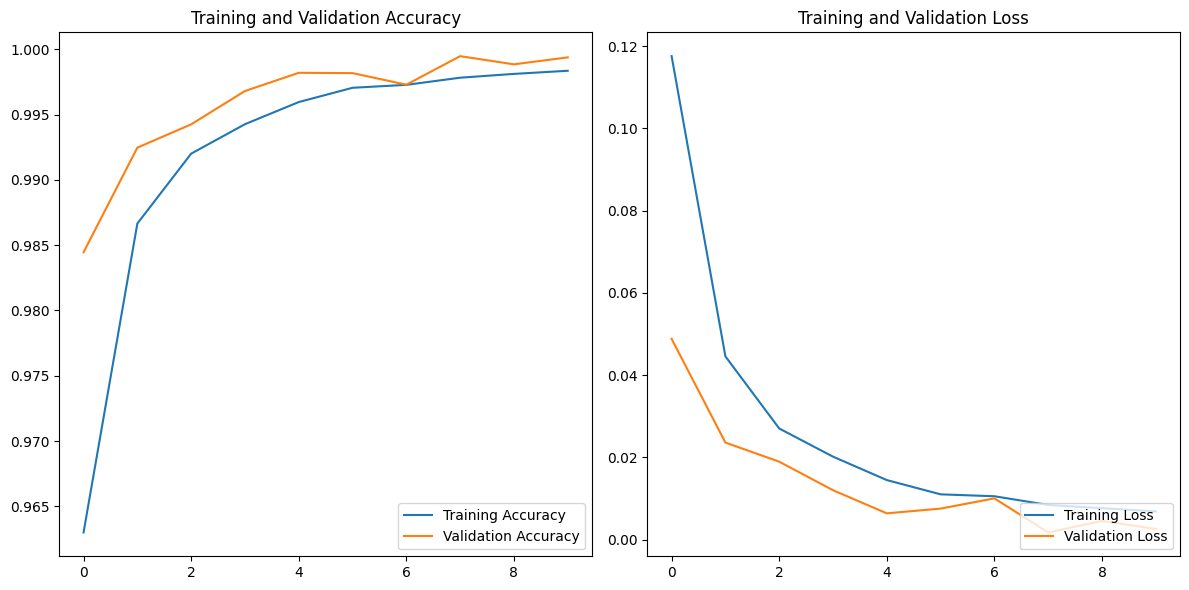

In [21]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_9 = Sequential([
    Input((WINDOW_LENGTH, NUM_FEATURES)),
    LSTM(100, return_sequences=False),
    Dropout(0.5),
    BatchNormalization(),
    Dense(50, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_9.summary()

model_9.save('../models/model_9/model_9_h27.keras')

start_time = time.time()

history_27 = model_9.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_9/history_27.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_27.history, file)


loss, accuracy = model_9.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_27)

---

---

## **Comparação dos Resultados Obtidos**

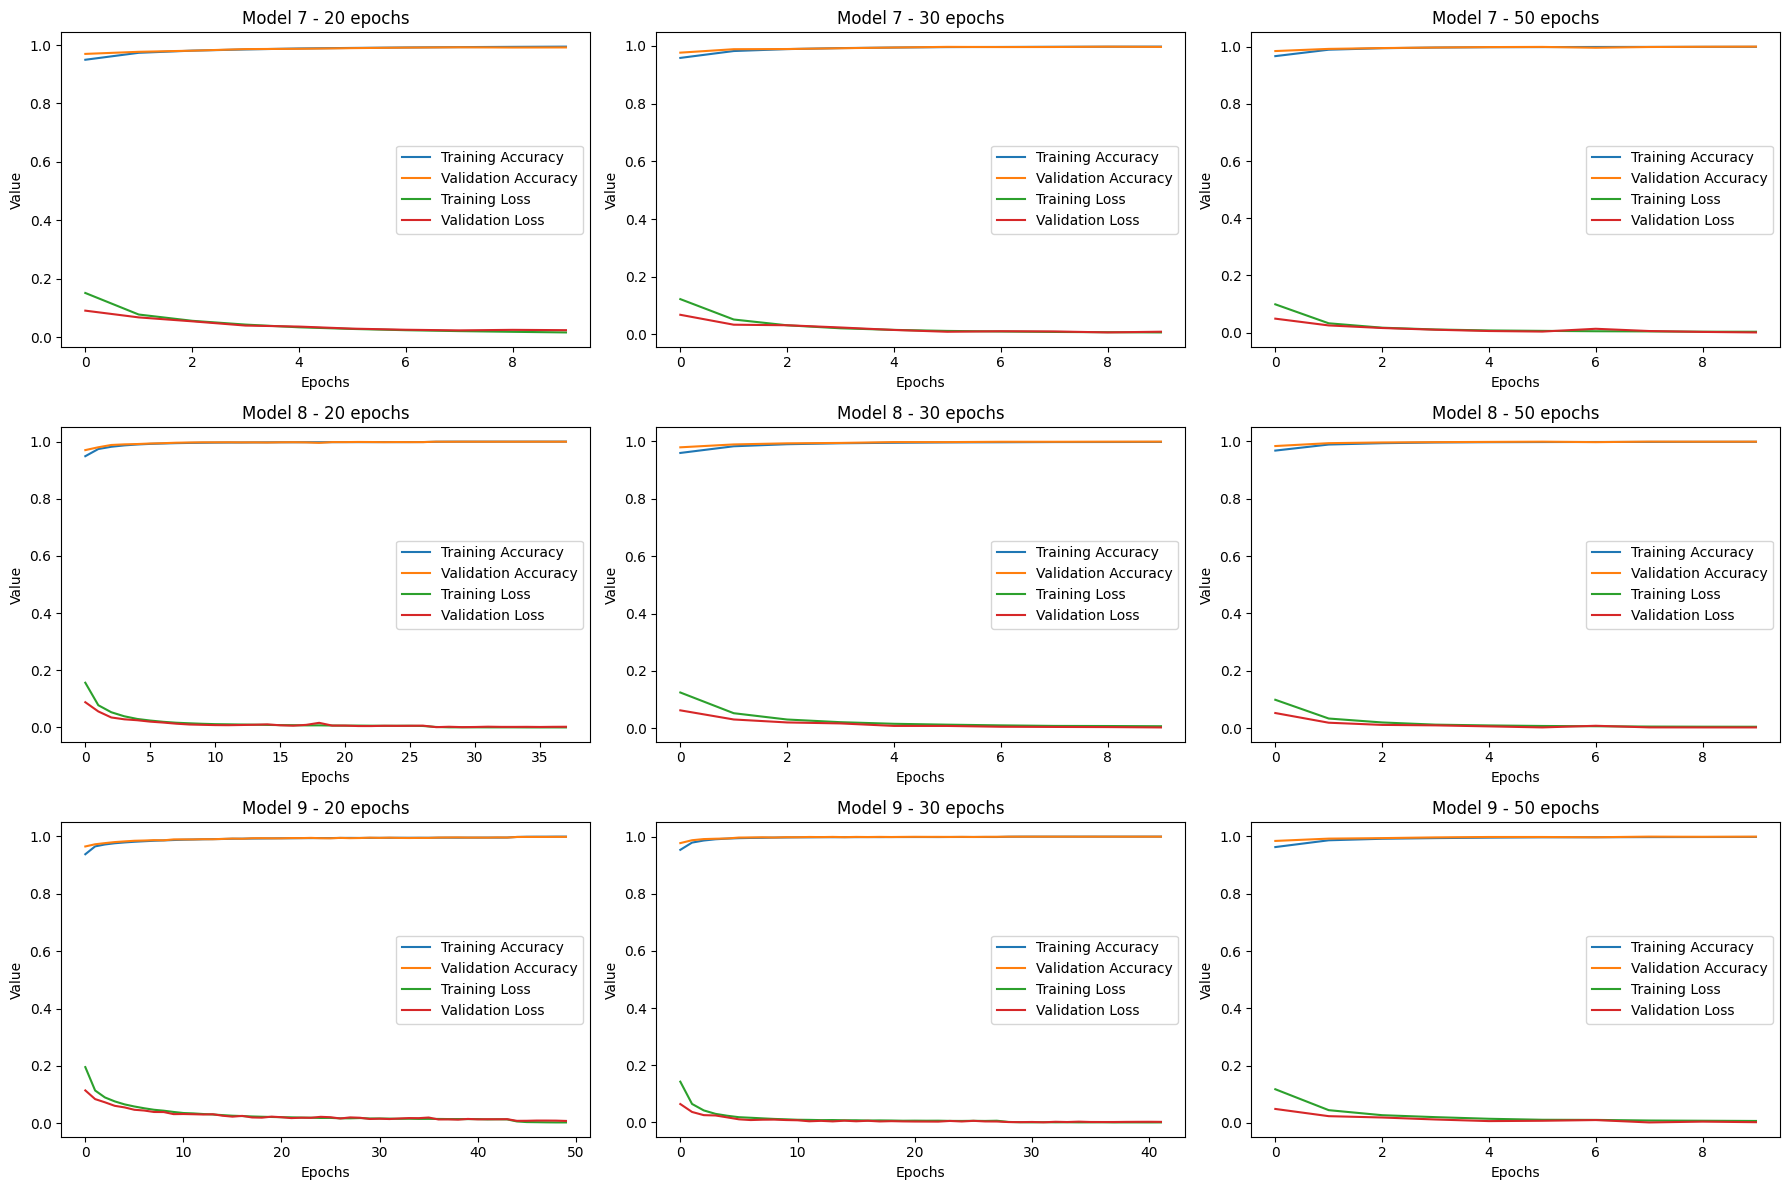

In [6]:
# Função para carregar os históricos
def load_history(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

# Carregar os históricos salvos
history_19_path = '../models/model_7/history_19.pkl'
history_20_path = '../models/model_7/history_20.pkl'
history_21_path = '../models/model_7/history_21.pkl'
history_22_path = '../models/model_8/history_22.pkl'
history_23_path = '../models/model_8/history_23.pkl'
history_24_path = '../models/model_8/history_24.pkl'
history_25_path = '../models/model_9/history_25.pkl'
history_26_path = '../models/model_9/history_26.pkl'
history_27_path = '../models/model_9/history_27.pkl'

# Carregar os históricos
history_19 = load_history(history_19_path)
history_20 = load_history(history_20_path)
history_21 = load_history(history_21_path)
history_22 = load_history(history_22_path)
history_23 = load_history(history_23_path)
history_24 = load_history(history_24_path)
history_25 = load_history(history_25_path)
history_26 = load_history(history_26_path)
history_27 = load_history(history_27_path)

# Lista de históricos para apresentar os gráficos
histories = [history_19, history_20, history_21, history_22, history_23, history_24, history_25, history_26, history_27]
labels = ['Model 7 - 20 epochs', 'Model 7 - 30 epochs', 'Model 7 - 50 epochs', 'Model 8 - 20 epochs', 'Model 8 - 30 epochs', 'Model 8 - 50 epochs', 'Model 9 - 20 epochs', 'Model 9 - 30 epochs', 'Model 9 - 50 epochs']

# Função para apresentar os gráficos dos múltiplos históricos
def plot_multiple_histories(histories, labels):
    plt.figure(figsize=(18, 12))

    for i, (history, label) in enumerate(zip(histories, labels)):
        plt.subplot(3, 3, i+1)

        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        
        plt.title(label)
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_multiple_histories(histories, labels)
